<div style="float:left">
    <h1 style="width:450px">Live Coding 7: NLTK and Friends</h1>
    <h2 style="width:450px">Working with Textual Data!</h2>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

<div style="border: dotted 1px rgb(156,121,26); padding: 10px; margin: 5px; background-color: rgb(255,236,184)"><i>Note</i>: You should download this notebook from GitHub and then save it to your own copy of the repository. I'd suggest adding it (<tt>git add Live-...</tt>) right away and then committing (<tt>git commit -m "Some message"</tt>). Do this again at the end of the class and you'll have a record of everything you did, then you can <tt>git push</tt> it to GitHub.</div>

## Preamble

This practical has been written using `nltk`, but would be _relatively_ easy to rework using `spacy` _except_ that you'd have to first load the requisite models:
```python
import spacy
nlp = spacy.load("en_core_web_sm") # `...web_md` and `...web_lg` are also options
```
You can [read about the models](https://spacy.io/models/en), and note that they are also [available in other languages](https://spacy.io/usage/models).

#### Required Modules

Notice that here we need rather a larger number of modules and functions!

In [1]:
import os
import pandas as pd
import geopandas as gpd
import re
import string
import unicodedata
from bs4 import BeautifulSoup

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

/home/shiraozhang/miniconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1dev-CAPI-1.14.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
from sklearn.preprocessing import OneHotEncoder # We don't use this but I point out where you *could*
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [50]:
import nltk
import spacy
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords
stopword_list = set(stopwords.words('english'))

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
#from nltk.tokenize.stanford import StanfordTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk import ngrams, FreqDist

lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/shiraozhang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/shiraozhang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/shiraozhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/shiraozhang/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


This next is just a small utility function that allows us to output Markdown (like this cell) instead of plain text:

In [4]:
from IPython.display import display_markdown

def as_markdown(head='', body='Some body text'):
    if head != '':
        display_markdown(f"##### {head}\n\n>{body}\n", raw=True)
    else:
        display_markdown(f">{body}\n", raw=True)

#### Loading and Tidying the Data

Let's only load a subset of the columns--we don't need all 70+ fields, just a few that might be useful for textual analysis:

In [5]:
cols = ['id','listing_url','name','price','description','host_id','host_about','host_listings_count',
        'latitude','longitude','property_type','room_type','accommodates',
        'bathrooms','bathrooms_text','bedrooms','beds','amenities',]

url = 'https://github.com/jreades/i2p/blob/master/data/src/2020-08-24-listings.csv.gz?raw=true' 

df = pd.read_csv(url, usecols=cols, compression='gzip', low_memory=False)
df['price'] = df.price.str.replace('$','').str.replace(',','').astype(float)

/tmp/ipykernel_470/2022840491.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = df.price.str.replace('$','').str.replace(',','').astype(float)


In [6]:
df.drop(df[((df.latitude.isna())|(df.longitude.isna()))].index, axis=0, inplace=True)
df.drop(df[((df.latitude < 40)|(df.longitude > 1))].index, axis=0, inplace=True)
print(df.shape)

(74184, 18)


#### Remove NA Values from Text Fields

<div style="border: dotted 1px rgb(156,121,26); padding: 10px; margin: 5px; background-color: rgb(255,236,184)"><i>Note</i>: I would be very wary of doing this in a 'proper' application, but to make our lives easier, we're going to drop rows where one of these values is NaN _now_ so it will simplify the steps below. In reality, I would spend quite a bit more time investigating which values are NaN and why before simply dropping them.</div>

Anyway, drop all NaN values:

In [7]:
df.drop(index=(df[(df.description.isna()) | (df.amenities.isna()) | (df.host_about.isna())].index), inplace=True)
print(df.shape)

(41194, 18)


Notice the scale of that change: according to my queries, we had 74,184 records after dropping rows that were unmappable, but for rows that are missing information about the description, amenities, and host, we've lost nearly half! 

#### Convert to GeoPandas

Read in the Boroughs GeoPackage so that we have a bit more geography here. I'm doing this from GitHub but you could change the URL to be a local file instead if you've already downloaded the file and don't want to download it every time you run this script. We then reproject the InsideAirbnb data to BNG and plot using price as a colormap.

In [8]:
boros = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true')

/home/shiraozhang/miniconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [9]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude, crs='epsg:4326'))
gdf = gdf.to_crs('epsg:27700')

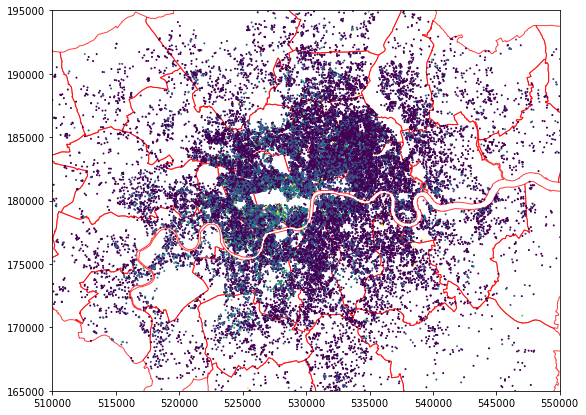

In [10]:
ax = boros.plot(figsize=(10,7), edgecolor='red', facecolor='none', linewidth=1, alpha=0.75)
gdf.plot(markersize=1, column='price', cmap='viridis', scheme='Fisher_Jenks_Sampled', ax=ax)
ax.set_xlim([510000, 550000])
ax.set_ylim([165000, 195000]);

## Previewing Textual Data

It's helpful to have a sense of what these data look like before trying to do something with them. You can also change the amount of preview text provided using the pandas options:
```python
print(pd.options.display.max_colwidth) # What's this currently set to?
pd.options.display.max_colwidth=100    # What do we want to set it to?
```

<div style="border: dotted 1px green; padding: 10px; margin: 5px; background-color: rgb(249,255,249);"><i>Hint</i>: In a full text-mining application I would spend a lot more time on this stage: sampling, looking at descriptions in full, performing my analysis (the rest of the steps) and then coming back with a deeper understanding of the data to make further changes to the analysis.</div>

In [11]:
print(pd.options.display.max_colwidth) # What's this currently set to?
pd.options.display.max_colwidth=None   # None = no maximum column width (you probably don't want to leave it at this)

50


#### Description

In [12]:
# Technically, the `isna` is no longer needed, but I left it here for 
# illustrative purposes about how I went about researching what was in
# the data before filtering it out in the cell block up above
gdf[~gdf.description.isna()].description.sample(8, random_state=42)

37453                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         My appartement has independent kitchen and bathroom. It is close to Lewisham train station and DLR station. It’s only 3-minute walk to supermarket and 10-minute walk distance to the shopping centre. You can take buses, trains and DLR to central London.<br /><br /><b>The space</b><br />Gym; Terrace; Study room; Laundry<br /><br /><b>Guest access</b><br />A terrace is available to use.<br /><br /><b>Other things to note</b><br />Please enquire me to check the days of availability and the way of handover

#### About the Host

In [13]:
gdf.host_about.sample(8, random_state=42)

37453                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               I work in the higher education sector.
3518             We are family of artists, filmmakers, business consultants. I've been living across Europe and India for most of my adult life while the rest of my family is based in Kolkata and Mumbai. We love receiving guests ever since i can remember as a little gi

#### Amenities

We don't do anything with this column across the remainder of the notebook, but you'll note that this is a list in the form of a string so you would need to 'deserialise' it using either regular expressions/str.split() _or_ `eval` (more on that [here](https://www.programiz.com/python-programming/methods/built-in/eval)) which is a seriously dangerous method if you don't know what you're doing and/or don't do any checking of the input. To my mind this would be a good candidate for One-Hot encoding after doing a little investigation of the frequency-of-use (_ie_ do you want to dedicate an entire column in an 80k data frame to an amenity that only occurs in 2 listings?).

In [14]:
gdf.amenities.sample(8, random_state=42)

37453                                                                                                                                                                                                                                                                                       ["Private living room", "Elevator", "Hot water", "Gym", "Hair dryer", "Kitchen", "Essentials", "Heating", "Hangers", "Laptop-friendly workspace", "Washer", "Dryer", "Shampoo", "Smoke alarm", "Wifi", "Lock on bedroom door", "Fire extinguisher"]
3518     ["Host greets you", "Paid parking off premises", "Elevator", "Refrigerator", "Children\u2019s books and toys", "Dryer", "Hangers", "Indoor fireplace", "Bed linens", "Iron", "Hot water", "Kitchen", "First aid kit", "Smoke alarm", "Carbon monoxide alarm", "Dishes and silverware", "Cooking basics", "Extra pillows and blankets", "Wifi", "Stove", "Fire extinguisher", "Children\u2019s dinnerware", "Essentials", "Washer", "Oven", "Shampoo", "Hair dryer", "Laptop-fri

## Using Regular Expressions

There is a _lot_ that can be done with Regular Expressions to identify relevant records in textual data and we're going to use this as a starting point for the rest of the analysis. I would normally consider the regexes here a 'first pass' at the data, but would look very carefully at the output of the TF/IDF vectorizer, Count vectorizer, and LDA to see if I could improve my regexes for further cycles of analysis... the main gain there is that regexes are _much_ faster than using the full NLP (Natural Language Processing) pipeline on the _full_ data set each time. As an alternative, you could develop the pipeline using a random subsample of the data and then process the remaining records sequentially -- in this context there is no justification for doing that, but with a larger corpus it might make sense.

#### Luxury Accommodation

I would encourage you to consider what other words might help to signal 'luxury'... perhaps words like 'stunning' or 'prestigious'? Could you add those to the regex?

In [15]:
gdf[gdf.description.str.contains(r'luxur(?:y|ious)', regex=True, flags=re.IGNORECASE)].description.sample(15, random_state=42)

70180                                                                                                                                                                                Located in a serene and upscale part of North-West London is this  Stylish and Luxuriously furnished three bedroom three bathroom semi-detached house.<br /><br />The first thought that comes to mind as you step through the front door is luxury. This property is newly refurbished to an exceptional high standard and can comfortably sleep 6 persons.<br /><br /><b>The space</b><br />This gorgeous and spacious home spread over two floors boasts of three double bedrooms with two en-suite bathrooms, family bathroom / toilet and a guest toilet. <br /><br />There are two living rooms with one of the living rooms having a dining section and open plan kitchen. The dining section opens up to a large garden ideal for a family choosing to relax for the evening or having a barbecue. The property comes with two front parkin

Assign it to a new data frame called `lux`:

In [16]:
lux = gdf[gdf.description.str.contains(r'luxur(?:y|ious)', regex=True, flags=re.IGNORECASE)].copy()
print(lux.shape)

(3203, 19)


And plot:

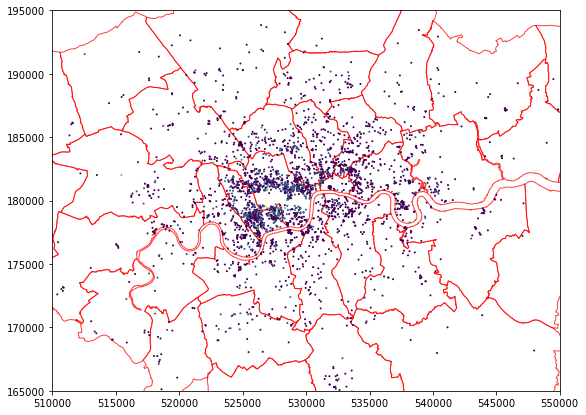

In [17]:
ax = boros.plot(figsize=(10,7), edgecolor='red', facecolor='none', linewidth=1, alpha=0.75)
ax = lux.plot(markersize=1, column='price', cmap='viridis', scheme='Fisher_Jenks_Sampled', ax=ax)
ax.set_xlim([510000, 550000])
ax.set_ylim([165000, 195000]);

#### Budget Accommodation

What words can you think of that might help you to spot affordable and budget accommodation? Start with just a couple of words and then I would encourage you to consider what _other_ words might help to signal 'affordability'... perhaps words like 'cosy' or 'charming' and then think about how you could you add those to the regex?

In [18]:
gdf[gdf.description.str.contains(r'(?:affordable|budget|cheap)', regex=True, flags=re.IGNORECASE)].description.sample(15, random_state=42)

41847                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Match box size room available with a 1,5 single bed.  (wider than a single bed) <br />Good for those looking for a cheap city break accommodation.<br />Cleaning fee apply per month, if your payment comes monthly, the fee will be asked vi

In [19]:
aff = gdf[gdf.description.str.contains(r'(?:affordable|budget|cheap)', regex=True, flags=re.IGNORECASE)].copy()
print(aff.shape)

(583, 19)


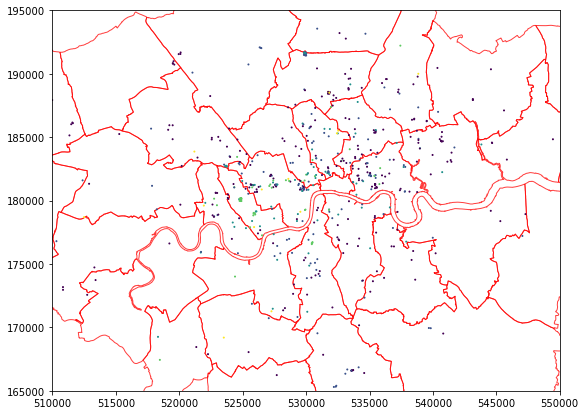

In [20]:
ax = boros.plot(figsize=(10,7), edgecolor='red', facecolor='none', linewidth=1, alpha=0.75)
ax = aff.plot(markersize=1, column='price', cmap='viridis', scheme='Fisher_Jenks_Sampled', ax=ax)
ax.set_xlim([510000, 550000])
ax.set_ylim([165000, 195000]);

#### Near Greenspace

Now see if you can work out a regular expression to find accommodation that emphasises accessibility to greenspace as part of the description? One thing you'll need to tackle is that many listings seem to say something about _parking_ and you wouldn't want those be returned as part of a regex looking for _parks_.

In [21]:
print(pd.options.display.max_colwidth)
pd.options.display.max_colwidth=100
gdf[gdf.description.str.contains(r' parks?\b', regex=True, flags=re.IGNORECASE)].description.sample(15, random_state=42)
pd.options.display.max_colwidth=30

None


In [22]:
green = gdf[gdf.description.str.contains(r' parks?\b', regex=True, flags=re.IGNORECASE)].copy()
print(green.shape)

(11099, 19)


In [23]:
parks = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Greenspace.gpkg?raw=true')

/home/shiraozhang/miniconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


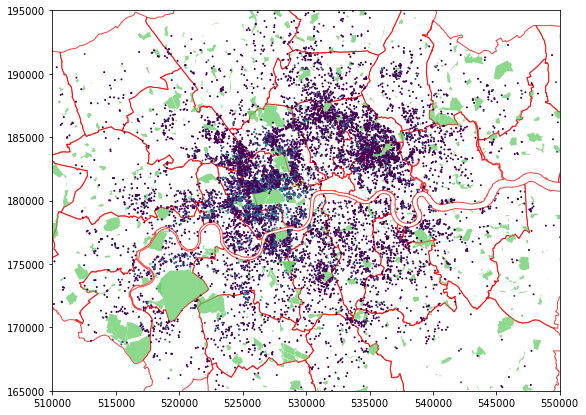

In [24]:
ax = boros.plot(figsize=(10,7), edgecolor='red', facecolor='none', linewidth=1, alpha=0.75)
parks.plot(edgecolor='none', facecolor=(0.4, 0.8, 0.4, 0.75), ax=ax)
green.plot(markersize=1, column='price', cmap='viridis', scheme='Fisher_Jenks_Sampled', ax=ax)
ax.set_xlim([510000, 550000])
ax.set_ylim([165000, 195000]);

## Illustrative Text Cleaning

Now we're going to step through the _parts_ of the process that we apply to clean and transform text. We'll do this individually before using a function to apply them _all at once_.

In [25]:
from urllib.request import Request, urlopen
url = 'https://www.ucl.ac.uk/bartlett/casa/about'
req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})

the_html = urlopen(req).read()

In [26]:
the_html[:250]

b'<!DOCTYPE html>\n<!--[if IE 7]>\n<html lang="en" class="lt-ie9 lt-ie8 no-js"> <![endif]-->\n<!--[if IE 8]>\n<html lang="en" class="lt-ie9 no-js"> <![endif]-->\n<!--[if gt IE 8]><!-->\n<html lang="en" class="no-js"> <!--<![endif]-->\n<head>\n  <meta name="vie'

### Lower Case

We also do some basic filtering on empty lines and I'm going to cheat a little by extracting only the 'About Us' section of the document (you would use BS4 to do this normally):

In [27]:
lower = [x.lower() for x in the_html.decode("utf-8").split("\n") if not re.match("^\s*$", x)]

In [28]:
for l in lower[175:176]:
    as_markdown("Content", l)

##### Content

></div>casa was established in 1995 to lead the development of a science of cities drawing upon methods and ideas in modelling, sensing the urban environment, visualisation and computation.<p>we seek to examine and offer solutions to the problems of resource efficiency and effective planning and governance shared by all cities. our vision is to play a central role in the science of smart cities – applying it to city planning, policy and architecture in the pursuit of making our cities better places to live.</p><p>based in bloomsbury, london, casa is our living laboratory. as one of the world’s truly global metropolises there is nowhere more ideal than london for learning about the challenges confronting modern cities.</p><p>casa has established a concentration of academics with a wide breadth of expertise from a range of disciplines, all with a common domain knowledge in cities.</p><h2 class="heading">our vision</h2><p>casa's focus is to be at the forefront of what is one of the grand challenges of 21st century science: to build a science of cities from a multidisciplinary base, drawing on cutting edge methods, and ideas in modeling, complexity, visualisation and computation.</p><p>our current mix of geographers, mathematicians, physicists, architects and computer scientists make casa a unique institute within ucl.</p><p>our vision is to be central to this new science, the science of smart cities, and relate it to city planning, policy and architecture in its widest sense.</p><p>the focus is on advancing the state of the art through research complemented by graduate study, teaching, consultancy and distance learning.</p><h2 class="heading">location</h2><p>the ucl centre for advanced spatial analysis is located at 90 tottenham court road, london, w1t 4tj. </p><p><a class="map-link map-link--0" href="//www.google.co.uk/maps/?z=15&amp;q=loc:51.521983,-0.1360091"><div class="map map--1">


### Removing HTML

In [29]:
cleaned = []
for l in lower[175:176]:
    tmp = re.sub(r'(\/[A-Za-z]+\d?|[A-Za-z]+ \/)>','\\1> ', l)
    soup = BeautifulSoup(tmp, "html.parser")
    if not re.match(r'^\s*$',soup.get_text()):
        cleaned.append(soup.get_text())

In [30]:
for c in cleaned:
    as_markdown("Listing", c)

##### Listing

> casa was established in 1995 to lead the development of a science of cities drawing upon methods and ideas in modelling, sensing the urban environment, visualisation and computation.we seek to examine and offer solutions to the problems of resource efficiency and effective planning and governance shared by all cities. our vision is to play a central role in the science of smart cities – applying it to city planning, policy and architecture in the pursuit of making our cities better places to live. based in bloomsbury, london, casa is our living laboratory. as one of the world’s truly global metropolises there is nowhere more ideal than london for learning about the challenges confronting modern cities. casa has established a concentration of academics with a wide breadth of expertise from a range of disciplines, all with a common domain knowledge in cities. our vision casa's focus is to be at the forefront of what is one of the grand challenges of 21st century science: to build a science of cities from a multidisciplinary base, drawing on cutting edge methods, and ideas in modeling, complexity, visualisation and computation. our current mix of geographers, mathematicians, physicists, architects and computer scientists make casa a unique institute within ucl. our vision is to be central to this new science, the science of smart cities, and relate it to city planning, policy and architecture in its widest sense. the focus is on advancing the state of the art through research complemented by graduate study, teaching, consultancy and distance learning. location the ucl centre for advanced spatial analysis is located at 90 tottenham court road, london, w1t 4tj.  


### Punctuation

We want to clear out punctuation using a regex that takes advantage of the `[...]` syntax:

In [31]:
pattern = re.compile(r'[,\.!\-><=\(\)\[\]\/&\'\"’;]+')
punkt   = []
for c in cleaned:
    punkt.append(re.sub(pattern, ' ', c))

In [32]:
for p in punkt:
    as_markdown("Listing", p)

##### Listing

> casa was established in 1995 to lead the development of a science of cities drawing upon methods and ideas in modelling  sensing the urban environment  visualisation and computation we seek to examine and offer solutions to the problems of resource efficiency and effective planning and governance shared by all cities  our vision is to play a central role in the science of smart cities – applying it to city planning  policy and architecture in the pursuit of making our cities better places to live  based in bloomsbury  london  casa is our living laboratory  as one of the world s truly global metropolises there is nowhere more ideal than london for learning about the challenges confronting modern cities  casa has established a concentration of academics with a wide breadth of expertise from a range of disciplines  all with a common domain knowledge in cities  our vision casa s focus is to be at the forefront of what is one of the grand challenges of 21st century science: to build a science of cities from a multidisciplinary base  drawing on cutting edge methods  and ideas in modeling  complexity  visualisation and computation  our current mix of geographers  mathematicians  physicists  architects and computer scientists make casa a unique institute within ucl  our vision is to be central to this new science  the science of smart cities  and relate it to city planning  policy and architecture in its widest sense  the focus is on advancing the state of the art through research complemented by graduate study  teaching  consultancy and distance learning  location the ucl centre for advanced spatial analysis is located at 90 tottenham court road  london  w1t 4tj   


### Stopword Removal

In [33]:
from nltk.corpus import stopwords
stopword_list = set(stopwords.words('english'))
stopped = []
for p in punkt:
    stopped.append(' '.join([x for x in re.split(r'\s+', p) if x not in stopword_list]))

In [34]:
for s in stopped:
    as_markdown("Listing", s)

##### Listing

> casa established 1995 lead development science cities drawing upon methods ideas modelling sensing urban environment visualisation computation seek examine offer solutions problems resource efficiency effective planning governance shared cities vision play central role science smart cities – applying city planning policy architecture pursuit making cities better places live based bloomsbury london casa living laboratory one world truly global metropolises nowhere ideal london learning challenges confronting modern cities casa established concentration academics wide breadth expertise range disciplines common domain knowledge cities vision casa focus forefront one grand challenges 21st century science: build science cities multidisciplinary base drawing cutting edge methods ideas modeling complexity visualisation computation current mix geographers mathematicians physicists architects computer scientists make casa unique institute within ucl vision central new science science smart cities relate city planning policy architecture widest sense focus advancing state art research complemented graduate study teaching consultancy distance learning location ucl centre advanced spatial analysis located 90 tottenham court road london w1t 4tj 


### Lemmatisation vs Stemming

In [35]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer 

In [36]:
lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize('monkeys'))
print(lemmatizer.lemmatize('cities'))
print(lemmatizer.lemmatize('complexity'))
print(lemmatizer.lemmatize('Reades'))

monkey
city
complexity
Reades


In [37]:
stemmer = PorterStemmer()
print(stemmer.stem('monkeys'))
print(stemmer.stem('cities'))
print(stemmer.stem('complexity'))
print(stemmer.stem('Reades'))

monkey
citi
complex
read


In [38]:
stemmer = SnowballStemmer(language='english')
print(stemmer.stem('monkeys'))
print(stemmer.stem('cities'))
print(stemmer.stem('complexity'))
print(stemmer.stem('Reades'))

monkey
citi
complex
read


In [39]:
lemmatizer = WordNetLemmatizer()
lemmas = []
for s in stopped:
    lemmas.append(' '.join([lemmatizer.lemmatize(x) for x in s.split(' ')]))

In [40]:
for l in lemmas:
    as_markdown('Listing',l)

##### Listing

> casa established 1995 lead development science city drawing upon method idea modelling sensing urban environment visualisation computation seek examine offer solution problem resource efficiency effective planning governance shared city vision play central role science smart city – applying city planning policy architecture pursuit making city better place live based bloomsbury london casa living laboratory one world truly global metropolis nowhere ideal london learning challenge confronting modern city casa established concentration academic wide breadth expertise range discipline common domain knowledge city vision casa focus forefront one grand challenge 21st century science: build science city multidisciplinary base drawing cutting edge method idea modeling complexity visualisation computation current mix geographer mathematician physicist architect computer scientist make casa unique institute within ucl vision central new science science smart city relate city planning policy architecture widest sense focus advancing state art research complemented graduate study teaching consultancy distance learning location ucl centre advanced spatial analysis located 90 tottenham court road london w1t 4tj 


## Applying Normalisation

The above approach is fairly hard going since you need to loop through every list element applying these changes one at a time. Instead, we can use pandas `apply` method together with some code built on top of work by others to simplify this process even though it will still be processor-intensive.

#### Downloading the Custom Module

You will need to download _and_ unzip [this file](https://github.com/jreades/i2p/blob/master/practicals/textual.zip?raw=true) into the directory where this notebook is running (since the `import` will look for a directory named `textual` wherever this code is running. The custom module is not perfect, but it gets the job done... mostly.

#### Importing the Custom Module

Now let's import it.

In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import textual

In [48]:
from textual import *

In [51]:
as_markdown('Normalised', normalise_document(the_html.decode("utf-8")))

#### Normalised

>bartlett centre advanced spatial analysis ucl university college london close ucl home prospective student current student staff give bartlett centre advanced spatial analysis home home people study research publication partnerships news event casa seminar series 2021 ucl home bartlett centre advanced spatial analysis ucl home bartlett centre advanced spatial analysis centre advanced spatial analysis casa interdisciplinary research institute focus science city within bartlett faculty build environment ucl casa establish 1995 lead development science city draw upon method idea modelling sense urban environment visualisation computation seek examine offer solution problem resource efficiency effective planning governance share city vision play central role science smart city apply city planning policy architecture pursuit make city well place live base bloomsbury london casa live laboratory one worl truly global metropolis nowhere ideal london learn challenge confront modern city casa establish concentration academic wide breadth expertise range discipline common domain knowledge city vision casas focus forefront one grand challenge 21st century science build science city multidisciplinary base draw cut edge method idea modeling complexity visualisation computation current mix geographer mathematician physicist architect computer scientist make casa unique institute within ucl vision central new science science smart city relate city planning policy architecture wide sense focus advance state art research complement graduate study teaching consultancy distance learning location ucl centre advanced spatial analysis locate tottenham court road london w1t 4tj view map contact address ucl centre advanced spatial analysis first floor tottenham court road london w1t 4tj telephone +44 3108 3877 student enquiry please contact mohammod hussain tel +44 3108 3327 enquiry please email casa ucl job vacancy casa list also follow twitter connect linkedin tweet casaucl ucl facility ucl faculty department library museum collection ucl bloomsbury theatre ucl shop ucl location map building ucl london ucl global ucl east connect ucl alumnus business medium relation job support university college london gower street london wc1e 6bt tel +44 7679 2000 copyright 2021 ucl disclaimer freedom information accessibility privacy cooky slavery statement contact


## Revenons à Nos Moutons

Now that you've seen how the steps are applied to a 'random' HTML document, let's get back to the problem at hand (revenons à nos moutons == let's get back to our sheep).

In [52]:
lux['description_norm'] = lux.description.apply(normalise_document)

In [53]:
aff['description_norm'] = aff.description.apply(normalise_document)

In [54]:
green['description_norm'] = green.description.apply(normalise_document)

#### Full File

<div style="border: dotted 1px red; padding: 10px; margin: 5px; background-color: rgb(255,249,249);"><i>Warning</i>: This code can take <i>some time</i> to run, so <b>don't run this now</b> as we're just going to work with the subsets!</div>


You will get a warning about `"." looks like a filename, not markup` -- this looks a little scary, but is basically suggesting that we have a description that consists only of a '.'. 

In [48]:
gdf['description_norm'] = ''
gdf['description_norm'] = gdf.description.apply(normalise_document)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/bs4/__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/opt/conda/envs/sds2021/lib/python3.9/site-packages/bs4/__init__.py:417: MarkupResemblesLocatorWarning: "https://www.facebook.com/106642570962328/posts/147604976866087/?d=n" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [49]:
gdf.to_file(os.path.join('data','2020-08-24-listings-with-nlp-subset.gpkg'), driver='GPKG')
#gdf.to_file(os.path.join('2020-08-24-listings-with-nlp-subset.gpkg'), driver='GPKG')

## Feature Extraction

See useful tutorial [here](https://towardsdatascience.com/tf-idf-explained-and-python-sklearn-implementation-b020c5e83275). Although we shouldn't have any empty descriptions, by the time we've finished normalising the textual data we may have _created_ some empty values and we need to ensure that we don't accidentally pass a NaN to the vectorisers and frequency distribution functions.

In [55]:
corpus = lux.description_norm.fillna(' ').values

In [56]:
print(corpus[0:2])

['perfect studio apartment separate kitchen wet room extra double sofa bed also provide great work space amazing view bushy park space luxury fully service self contain apartment avalable moment hamton court palace locate within beautiful georgain build studio fully equip really comfortable stay underfloor heating towel linen fully equip kitchen car parking internet include price guest access whole apartment enjoy'
 'best view london far exceed expectation fab bedroom suite glorious terrace incredibly quiet central trendy hood walk covent garden share home best ever london experience space high rise living spectacular sunshine pours triple aspect floor ceiling window view take nigh every major london landmark pau cathedral london eye gherkin tate modern telecom tower canary wharf 1500 yes 1500 foot wrap around terrace enjoy view outdoor din throughout summer even splendid vista offer move turn back window yol find two large double bedroom enormous open plan live space equip beautiful l

#### Frequency Distributions

Regular expressions _again_! See, we use them all over the place. See if you can expand the regex to suppress all punctuation _and_ numbers. This is a metacharacter problem.

One new thing you'll see here is the `ngram`: ngrams are 'simply' pairs, or triplets, or quadruplets of words. You may come across the terms unigram (`ngram(1,1)`), bigram (`ngram(2,2)`), trigram (`ngram(3,3)`)... typically, you will rarely find anything beyond trigrams, and these present real issues for text2vec algorithms because the embedding for `geographical`, `information`, and `systems` is _not_ the same as for `geographical information systetms`.

In [57]:
data = [x for x in ' '.join(corpus).split() if not re.match(r'[,.\-\(\)!\&0-9\;\:]', x)]

fcounts = dict()

for size in 1, 2, 3:
    fdist = FreqDist(ngrams(data, size))
    print(fdist)
    # If you only need one, note this: https://stackoverflow.com/questions/15145172/nltk-conditionalfreqdist-to-pandas-dataframe
    fcounts[size] = pd.DataFrame.from_dict({f'Ngram Size {size}': fdist})

<FreqDist with 7773 samples and 266201 outcomes>
<FreqDist with 88160 samples and 266200 outcomes>
<FreqDist with 159980 samples and 266199 outcomes>


In [58]:
for dfs in fcounts.values():
    print(dfs.sort_values(by=dfs.columns.values[0], ascending=False).head(10))

           Ngram Size 1
apartment          5039
bedroom            4419
space              4137
london             3854
room               3584
bed                3016
kitchen            2788
luxury             2633
bathroom           2395
flat               2298
                   Ngram Size 2
guest   access             1029
living  room                916
minute  walk                895
central london              876
fully   equip               828
open    plan                706
double  bed                 686
        bedroom             682
bedroom apartment           676
two     bedroom             493
                               Ngram Size 3
fully     equip     kitchen             385
king      size      bed                 322
open      plan      kitchen             252
two       bedroom   apartment           222
guest     access    guest               212
apartment fully     equip               170
bedroom   apartment locate              170
double    sofa      bed         

#### Count Vectoriser

In [59]:
vectorizer = CountVectorizer(ngram_range=(1,3))
vectorizer.fit(corpus)

CountVectorizer(ngram_range=(1, 3))

Note all of the methods available to interrogate the transformer:

In [60]:
dir(vectorizer)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_char_ngrams',
 '_char_wb_ngrams',
 '_check_n_features',
 '_check_stop_words_consistency',
 '_check_vocabulary',
 '_count_vocab',
 '_get_param_names',
 '_get_tags',
 '_limit_features',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_sort_features',
 '_stop_words_id',
 '_validate_data',
 '_validate_params',
 '_validate_vocabulary',
 '_warn_for_unused_params',
 '_white_spaces',
 '_word_ngrams',
 'analyzer',
 'binary',
 'build_analyzer',
 'build_preprocessor',
 'build_tokenizer',
 'decode',
 'decode_error',
 'dtype',
 'encoding',
 'fit',
 'fit_transform',
 'fixe

Find the number associated with a word in the vocabulary:

In [61]:
# Find the vocabulary mapping
print(vectorizer.vocabulary_['stratford'])

215399


How many times does it occur in the original corpus:

In [62]:
lux.description_norm.str.contains('stratford').sum()

52

Note the type of the transformed corpus:

In [63]:
tcorpus = vectorizer.transform(corpus)
tcorpus # tcorpus for transformed corpus

<3203x251761 sparse matrix of type '<class 'numpy.int64'>'
	with 728088 stored elements in Compressed Sparse Row format>

Here is the first document from the corpus:

In [64]:
lux.description_norm.iloc[0]

'perfect studio apartment separate kitchen wet room extra double sofa bed also provide great work space amazing view bushy park space luxury fully service self contain apartment avalable moment hamton court palace locate within beautiful georgain build studio fully equip really comfortable stay underfloor heating towel linen fully equip kitchen car parking internet include price guest access whole apartment enjoy'

In [65]:
doc_df = pd.DataFrame(tcorpus[0].T.todense(), index=vectorizer.get_feature_names(), columns=["Counts"])
doc_df.sort_values('Counts', ascending=False).head(10)

,Counts
fully,3
apartment,3
fully equip,2
kitchen,2
space,2
equip,2
studio,2
beautiful georgain,1
bushy park,1
bushy park space,1


#### TF/IDF Vectoriser

In [66]:
vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,3), max_df=0.5, min_df=0.05)
tcorpus    = vectorizer.fit_transform(corpus)

In [67]:
doc_df = pd.DataFrame(tcorpus[0].T.todense(), index=vectorizer.get_feature_names(), columns=["Weights"])
doc_df.sort_values('Weights', ascending=False).head(10)

,Weights
studio,0.375606
fully,0.305531
fully equip,0.251251
equip,0.230051
internet,0.197763
heating,0.191443
extra,0.185837
work,0.180367
build,0.179724
parking,0.177639


In [68]:
tfidf = pd.DataFrame(data=tcorpus.toarray(),
                        columns=vectorizer.get_feature_names())
tfidf.head()

,access,access entire,access guest,accommodation,additional,air,airport,airy,along,also,...,well,west,wharf,whole,wifi,window,within,wooden,work,would
0,0.091944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.118190,...,0.0,0.0,0.000000,0.176229,0.000000,0.000000,0.141628,0.000000,0.180367,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.166959,0.000000,0.124745,0.259158,0.000000,0.000000,0.000000,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.130405,0.000000,0.000000,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.131752,0.000000,0.170002,0.000000,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090832,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


## Word Clouds

#### For TF/IDF Weighted Words

In [69]:
tfidf.sum().sort_values(ascending=False)

flat                        183.556709
guest                       161.172529
walk                        155.407519
double                      153.203434
access                      149.899276
                               ...    
require                      25.261399
bedroom apartment locate     25.165820
fridge freezer               24.884304
home away                    24.279071
away home                    23.964250
Length: 344, dtype: float64

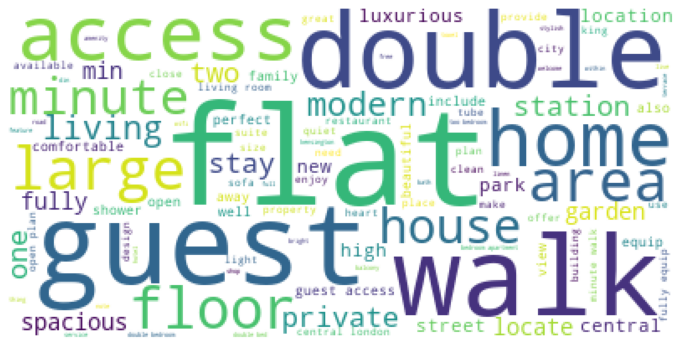

In [70]:
plt.figure(figsize=(12, 12))
Cloud = WordCloud(background_color="white", max_words=100).generate_from_frequencies(tfidf.sum())
plt.imshow(Cloud) 
plt.axis("off");

## Latent Dirchlet Allocation

Adapted from [this post](https://stackabuse.com/python-for-nlp-topic-modeling/) on doing LDA using sklearn. Most other examples use the `gensim` library, which isn't installed in the Docker image that I provided. You could install it on the command line (the _Jupyter_ command line!) but it will be lost every time you restart the server.

In [71]:
vectorizer = CountVectorizer(ngram_range=(2,2)) # Notice change to ngram range (try 1,1 and 1,2 for other options)

In [72]:
vectorizer.fit(corpus) 
tcorpus = vectorizer.transform(corpus) # tcorpus for transformed corpus

LDA = LatentDirichletAllocation(n_components=10, random_state=42) # Might want to experiment with n_components too
LDA.fit(tcorpus)

LatentDirichletAllocation(random_state=42)

In [73]:
first_topic = LDA.components_[0]
top_words = first_topic.argsort()[-25:]

for i in top_words:
    print(vectorizer.get_feature_names()[i])

secure development
first floor
equipped kitchen
double bedroom
bedroom bathroom
master bedroom
open plan
walk away
blueground apartment
double bed
offer apartment
hyde park
fully equipped
thing note
guest access
fully equip
great transport
equip kitchen
transport link
living room
minute walk
one bedroom
brand new
central london
bedroom apartment


In [74]:
for i,topic in enumerate(LDA.components_):
    as_markdown(f'Top 10 words for topic #{i}', ', '.join([vectorizer.get_feature_names()[i] for i in topic.argsort()[-25:]]))

#### Top 10 words for topic #0

>secure development, first floor, equipped kitchen, double bedroom, bedroom bathroom, master bedroom, open plan, walk away, blueground apartment, double bed, offer apartment, hyde park, fully equipped, thing note, guest access, fully equip, great transport, equip kitchen, transport link, living room, minute walk, one bedroom, brand new, central london, bedroom apartment


#### Top 10 words for topic #1

>oxford street, kitchen bathroom, london min, double sofa, bedroom bathroom, din table, bathroom shower, tube station, luxury apartment, hyde park, master bedroom, thing note, king size, double bedroom, size bed, open plan, equip kitchen, sofa bed, double bed, min walk, fully equip, living room, central london, minute walk, guest access


#### Top 10 words for topic #2

>king size, service apartment, two bedroom, tube station, hyde park, equip kitchen, heart london, bedroom bathroom, sofa bed, london space, double bed, one bedroom, bedroom flat, thing note, transport link, brand new, fully equip, double bedroom, living room, high standard, open plan, bedroom apartment, central london, guest access, minute walk


#### Top 10 words for topic #3

>high quality, shower room, london bridge, bed linen, luxury apartment, transport link, double room, sofa bed, tube station, wash machine, brand new, minute walk, thing note, size bed, bedroom apartment, equip kitchen, king size, open plan, double bed, min walk, double bedroom, central london, living room, fully equip, guest access


#### Top 10 words for topic #4

>thing note, open plan, wash machine, apartment locate, brand new, one bedroom, two bedroom, tube station, luxury apartment, master bedroom, sofa bed, bedroom bathroom, double bedroom, walk distance, double bed, equip kitchen, min walk, central london, guest access, bedroom apartment, minute walk, size bed, king size, living room, fully equip


#### Top 10 words for topic #5

>room include, oxford street, luxury two, double bedroom, thing note, place stay, double room, bed living, apartment fully, master bedroom, space apartment, living area, equip kitchen, open plan, brand new, min walk, minute walk, apartment locate, guest access, bedroom apartment, double bed, central london, two bedroom, fully equip, living room


#### Top 10 words for topic #6

>luxurious double, bedroom bathroom, long day, bright spacious, flat heart, tube station, fully fit, bedroom flat, comfortable space, make stay, whole apartment, stay comfortable, access whole, size bed, fully equip, brand new, king size, thing note, double bed, open plan, minute walk, double bedroom, central london, living room, guest access


#### Top 10 words for topic #7

>travel london, fast reliable, luxurious towel, space property, london desirable, close proximity, kitchen stock, perfect location, desirable location, major attraction, crockery cutlery, throw away, professionally clean, one london, bar restaurant, two bedroom, london perfect, amenity include, spacious living, double bedroom, open plan, central london, double bed, guest access, living room


#### Top 10 words for topic #8

>luxury mattress, king size, plan kitchen, hotel grade, linen luxury, grade bed, double bed, fresh linen, access entire, thing note, brand new, access guest, sofa bed, bed linen, plan live, kitchen din, two bedroom, central london, bedroom apartment, fully equip, living room, din area, double bedroom, guest access, open plan


#### Top 10 words for topic #9

>london apartment, apartment essential, private block, bed available, equip everything, place stay, family apartment, locate minute, short term, home away, away home, locate private, two bedroom, apartment fully, double bed, sofa bed, street station, double bedroom, fully equip, apartment suitable, bedroom apartment, central london, need place, minute walk, apartment locate


#### Maximum Likelihood Topic

In [75]:
tdf = lux # Saves having to change the variable name below for aff, green, etc.

In [76]:
topic_values = LDA.transform(tcorpus)
topic_values.shape

(3203, 10)

In [77]:
pd.options.display.max_colwidth=20
tdf['Topic'] = topic_values.argmax(axis=1)
tdf.head()

,id,listing_url,name,description,host_id,host_about,host_listings_count,latitude,longitude,property_type,...,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,geometry,description_norm,Topic
74,81080.0,https://www.airb...,Luxury Self cont...,Perfect Studio a...,439154.0,Craven House is ...,7.0,51.40644,-0.33563,Room in serviced...,...,2.0,NaN,1 bath,1.0,2.0,"[""Host greets yo...",130.00,POINT (515859.78...,perfect studio a...,8
80,81635.0,https://www.airb...,Clerkenwell pent...,"""Best views in L...",443041.0,You're renting m...,3.0,51.52842,-0.11141,Private room in ...,...,2.0,NaN,1.5 baths,1.0,1.0,"[""Host greets yo...",101.86,POINT (531104.02...,best view london...,0
81,81951.0,https://www.airb...,LONDON DETACHED ...,Available for mo...,445322.0,Hello .. I am a ...,1.0,51.58519,0.15639,Entire house,...,2.0,NaN,2 baths,1.0,1.0,"[""Wifi"", ""Kitche...",190.00,POINT (549492.91...,available 2018 f...,6
87,85406.0,https://www.airb...,Spacious 2bd 2bt...,A lovely large t...,467835.0,A creature of co...,2.0,51.51848,-0.18554,Entire apartment,...,4.0,NaN,2 baths,2.0,2.0,"[""Paid parking o...",152.00,POINT (525989.61...,lovely large two...,7
95,90358.0,https://www.airb...,Beautiful Kensin...,Amazing luxury a...,489949.0,"Hi, I traveled e...",2.0,51.49875,-0.19263,Entire apartment,...,4.0,NaN,2 baths,2.0,4.0,"[""Refrigerator"",...",187.29,POINT (525551.93...,amazing luxury a...,1


In [78]:
pd.options.display.max_colwidth=75
tdf[tdf.Topic==1].description.head(10)

95      Amazing luxury apartment for you to enjoy in Kensington, one of the mos...
97      •Central location<br />•Canary Wharf: 8 min walk<br />•Bank: 15 min<br ...
126     Situated in the heart of vibrant Clerkenwell, what many consider to be ...
195     Bright double room in beautifully renovated house, fronting large peace...
199     Situated in the heart of vibrant Clerkenwell, what many consider to be ...
727     <b>The space</b><br />Available for you to rent is a room in a luxuriou...
732     Please note, our house is only usually available during the school summ...
878     Luxury, recently renovated 3 bedroom, 3 bathroom home fully equipped wi...
949     Enjoy your own spacious and fully equipped studio in newly refurbishe​d...
1387    This 5th floor flat with views across north London has a luxury UK king...
Name: description, dtype: object

In [79]:
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english', analyzer='word', max_df=0.7, min_df=0.05)
topic_corpus = vectorizer.fit_transform(tdf[tdf.Topic==1].description.values) # tcorpus for transformed corpus

In [80]:
topicdf = pd.DataFrame(data=topic_corpus.toarray(),
                        columns=vectorizer.get_feature_names())

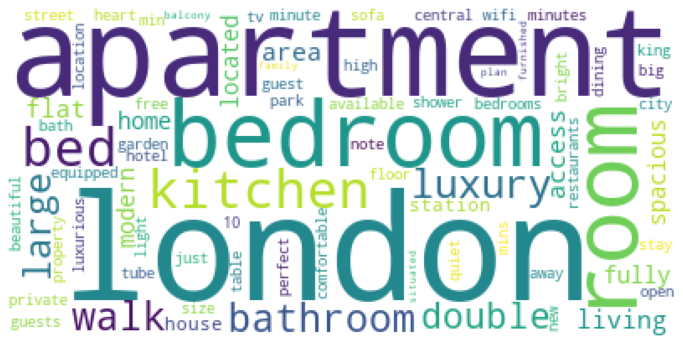

In [81]:
plt.figure(figsize=(12, 12))
Cloud = WordCloud(background_color="white", max_words=75).generate_from_frequencies(topicdf.sum())
plt.imshow(Cloud) 
plt.axis("off");

## Applications



The above is _still_ only the results for the 'luxury' apartments _alone_. At this point, you would probably want to think about how your results might change if you changed any of the following:

1. Using one of the other data sets that we created, or even the entire data set!
2. Applying the CountVectorizer or TfidfVectorizer _before_ selecting out any of our 'sub' data sets.
3. Using the visualisation of information from \#2 to improve our regex selection process.
4. Reducing, increasing, or constraining (i.e. `ngrams=(2,2)`) the size of the ngrams while bearing in mind the impact on processing time and interpretability.
5. Filtering by type of listing or host instead of keywords found in the description (for instance, what if you applied TF/IDF to the entire data set and then selected out 'Whole Properties' before splitting into those advertised by hosts with only one listing vs. those with multiple listings?).
6. Linking this back to the geography.

Over the next few weeks we'll also consider alternative means of visualising the data!

## Resources

There is a lot more information out there, including a [whole book](https://www.nltk.org/book/) and your standard [O'Reilly text](http://www.datascienceassn.org/sites/default/files/Natural%20Language%20Processing%20with%20Python.pdf).

And some more useful links:
- [Pandas String Contains Method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.contains.html)
- [Using Regular Expressions with Pandas](https://kanoki.org/2019/11/12/how-to-use-regex-in-pandas/)
- [Summarising Chapters from Frankenstein using TF/IDF](https://towardsdatascience.com/using-tf-idf-to-form-descriptive-chapter-summaries-via-keyword-extraction-4e6fd857d190)